In [2]:
import strategies as s
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from copy import copy

In [128]:
avs = pd.read_csv('./data/avs.csv', encoding='windows-1252')
avs = avs.melt()
x = avs.value
y = avs.variable
y = label_binarize(y, classes=['Wrong', 'Right'])
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [3]:
nbpipe = Pipeline([
    ('countvec', CountVectorizer()),
    ('idf', TfidfTransformer(use_idf=False)),
    ('nb', MultinomialNB())
])
params = {'nb__alpha': np.logspace(-4, 0, 100)}
nb = GridSearchCV(nbpipe, params, n_jobs=-1, cv=10, refit=True)
nb.fit(x_train, y_train);

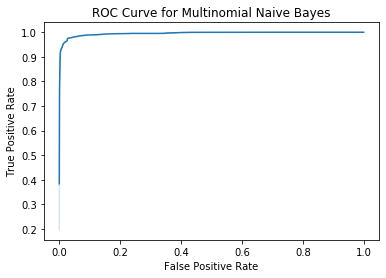

In [76]:
y_pred = nb.predict_proba(x_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
tpr, fpr, thresh = roc_curve(y_test, y_pred)
sns.lineplot(tpr, fpr)
plt.title('ROC Curve for Multinomial Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [78]:
accs = [accuracy_score(y_test, y_pred > th) for th in thresh]
best_i = np.argmax(accs)
print(accs[best_i])
best_th = thresh[best_i]
print(best_th)


0.973851030110935
0.4344199158467637


In [ ]:
model = (nb, best_th)
with open('nbmodel.pkl', 'wb') as f:
    pickle.dump(model, f)

In [2]:
with open('nbmodel.pkl', 'rb') as f:
    nb, thr = pickle.load(f)

In [8]:
dr = s.start_driver()
ops = s.get_options(dr)
nb.predict_proba(o.text for o in ops)[:, 1]


array([[9.99993318e-01, 6.68229000e-06],
       [4.05980447e-04, 9.99594020e-01]])

In [126]:
with open('./records/nb-3-30-2020.pkl', 'rb+') as f:
    record = pickle.load(f)
record = np.array(record)
np.sum(record) / len(record)

0.9403131115459883

In [127]:
with open('./records/cnb-3-30-2020.pkl', 'rb+') as f:
    record = pickle.load(f)
record = np.array(record)
np.sum(record) / len(record)

0.9324055666003976

In [7]:
def make_adversarial_data(df):
    
    df_nu = copy(df)
    df_nu.columns = ['x0', 'x1']
    df_nu['correct'] = np.zeros(len(df))

    def scramble_row(row):

        correct = np.random.choice([0, 1])
        outrow = [0, 0, correct]
        outrow[correct] = row[0]
        outrow[not correct] = row[1]

        return outrow
    
    df_nu = df.apply(scramble_row, axis=1, result_type='expand')
    return df_nu
    

In [8]:
avs_ad = pd.read_csv('./data/avs.csv', encoding='windows-1252')
avs_ad = make_adversarial_data(avs_ad)
x = avs_ad[[0,1]]
y = avs_ad[2]
x_train, x_test, y_train, y_test = train_test_split(x, y)
avs_ad.head()

,0,1,2
0,Towards Stueckelberg-Douglass Conditions in No...,"Dynamics of Higgs"" Fields and a Quintessence i...",1
1,Decoupling of Supersymmetric Particles in the ...,On a Check of a Firewall at the Planck Scale,0
2,Progress in Scattering Amplitudes in a Model f...,Complete Control of Gauge Parameter Dependence...,1
3,Semi-Empirical Bound on the Chlorinr-37 Solar ...,"Models of Dark Matter, a Resolution of the Hie...",0
4,Cosmic Microwave Background From Late-Decaying...,From Vanishing Gerbs to Topological TQFTs Surr...,0


In [18]:
ct_cv = ColumnTransformer([
    ('count0', CountVectorizer(), 0),
    ('count1', CountVectorizer(), 1)
])
nbpipe = Pipeline([
    ('countvec', ct_cv),
    ('nb', MultinomialNB())
])
params = {'nb__alpha': np.logspace(-4, 0, 100)}
nb = GridSearchCV(nbpipe, params, n_jobs=-1, cv=10, refit=True)
nb.fit(x_train, y_train);

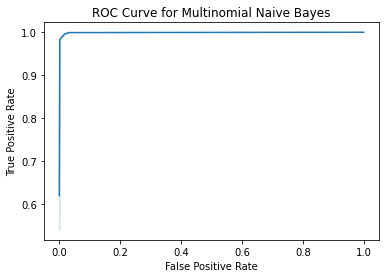

In [19]:
y_pred = nb.predict_proba(x_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
tpr, fpr, thresh = roc_curve(y_test, y_pred)
sns.lineplot(tpr, fpr)
plt.title('ROC Curve for Multinomial Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [21]:
accs = [accuracy_score(y_test, y_pred > th) for th in thresh]
best_i = np.argmax(accs)
print(accs[best_i])
best_th = thresh[best_i]
print(best_th)


0.991283676703645
0.9468375947442654


In [22]:
model = (nb, best_th)
with open('models/nbmodel_contrastive.pkl', 'wb') as f:
    pickle.dump(model, f)

In [13]:
z = list(avs_ad.iloc[0][0:2])
p = nb.predict_proba([z])
np.argmax(p)

1

In [14]:
avs_ad.iloc[0]

0    Towards Stueckelberg-Douglass Conditions in No...
1    Dynamics of Higgs" Fields and a Quintessence i...
2                                                    1
Name: 0, dtype: object

Fitting 10 folds for each of 45 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 10.0min finished


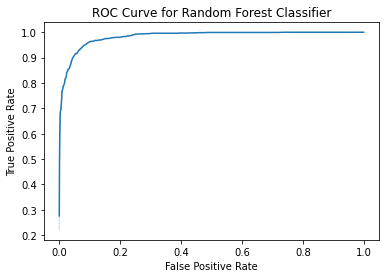

0.9334389857369255
0.4217391304347826


In [3]:
avs = pd.read_csv('./data/avs.csv', encoding='windows-1252')
avs = avs.melt()
x = avs.value
y = avs.variable
y = label_binarize(y, classes=['Wrong', 'Right'])
x_train, x_test, y_train, y_test = train_test_split(x, y)
rfpipe = Pipeline([
    ('countvec', CountVectorizer()),
    ('idf', TfidfTransformer(use_idf=False)),
    ('rf', RandomForestClassifier())
])
params = {'rf__n_estimators': range(50, 500, 10)}
rf = GridSearchCV(rfpipe, params, n_jobs=-1, cv=10, refit=True, verbose=2)
rf.fit(x_train, y_train);
y_pred = rf.predict_proba(x_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
tpr, fpr, thresh = roc_curve(y_test, y_pred)
sns.lineplot(tpr, fpr)
plt.title('ROC Curve for Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
accs = [accuracy_score(y_test, y_pred > th) for th in thresh]
best_i = np.argmax(accs)
print(accs[best_i])
best_th = thresh[best_i]
print(best_th)
model = (rf, best_th)
with open('models/rfc.pkl', 'wb') as f:
    pickle.dump(model, f)